### Trực quan hoá đa biến để tìm ra các đặc trưng quan trọng cho quá trình training

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
arsenal_df = pd.read_csv("../../raw_data/clean_and_transformation/arsenal.csv")

In [3]:
arsenal_df.columns

Index(['opponent', 'venue', 'season', 'result', 'win_percent_before_team1',
       'lose_percent_before_team1', 'draw_percent_before_team1',
       'win_percent_before_team2', 'lose_percent_before_team2',
       'draw_percent_before_team2', 'total_goals_before_team1',
       'total_lost_goals_before_team1', 'total_goals_before_team2',
       'total_lost_goals_before_team2', 'ELO_before_match_team1',
       'ELO_before_match_team2', 'ELO_after_match_team1',
       'ELO_after_match_team2', 'last_5_points_team1', 'last_5_points_team2',
       'date_time', 'head2head_win_percent', 'head2head_draw_percent',
       'head2head_lost_percent', 'is_opponent_big6'],
      dtype='object')

### 1. Xem xét sự ảnh hưởng của venue đến biến mục tiêu result

In [4]:
result_count = arsenal_df.groupby(['venue', 'result']).size().unstack().reindex(["W", "L", "D"], axis=1).reindex(["Home", "Away"])
venue_count = arsenal_df.groupby(['venue']).size().reindex(["Home", "Away"])

result_count

result,W,L,D
venue,,,
Home,295,53,90
Away,201,126,110


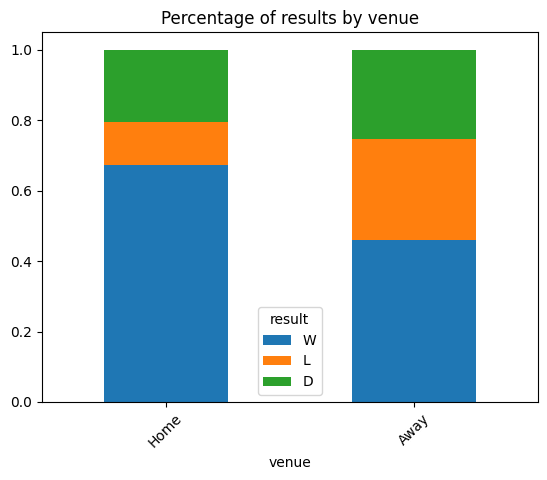

In [5]:
result_percentage = result_count.div(venue_count, axis=0)
result_percentage.plot(kind='bar', stacked=True)
plt.title("Percentage of results by venue")
plt.xticks(rotation=45);

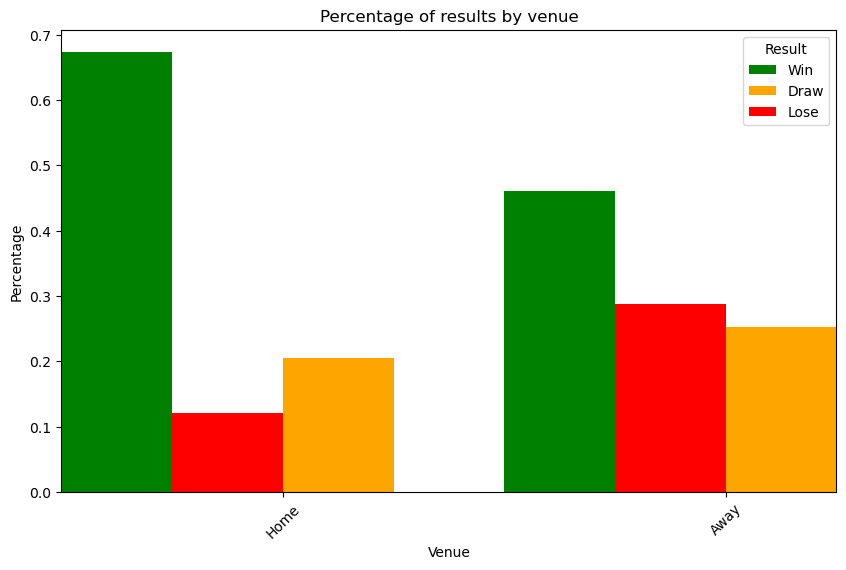

In [8]:
# Vẽ ba biểu đồ cột cho mỗi loại kết quả
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ biểu đồ cho kết quả Win
result_percentage['W'].plot(kind='bar', ax=ax, color='green', position=2, width=0.25, label='Win')

# Vẽ biểu đồ cho kết quả Draw
result_percentage['D'].plot(kind='bar', ax=ax, color='orange', position=0, width=0.25, label='Draw')

# Vẽ biểu đồ cho kết quả Lose
result_percentage['L'].plot(kind='bar', ax=ax, color='red', position=1, width=0.25, label='Lose')

plt.title("Percentage of results by venue")
plt.xlabel("Venue")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title='Result')

plt.show()

Nhận xét:
- Đá trên sân nhà luôn có tỉ lệ thắng, hoà cao hơn so với tỉ lệ thua. Tỉ lệ thắng là cao rõ rệt
- Còn khi đá trên sân khách thì tỉ lệ thắng có cao hơn so với tỉ lệ thua nhưng không rõ rệt như đá trên sân nhà

### 2. Xem xét sự ảnh hưởng của referee đến biến mục tiêu result

In [9]:
result_by_referee = arsenal_df.groupby(['referee', 'result']).size().unstack().reindex(["W", "L", "D"], axis=1).dropna(axis=0)
match_count_by_referee = arsenal_df.groupby(['referee']).size()

In [10]:
result_by_referee.head()

result,W,L,D
referee,,,
Alan Wiley,22.0,6.0,9.0
Andre Marriner,24.0,10.0,8.0
Andy Madley,1.0,1.0,1.0
Anthony Taylor,22.0,8.0,11.0
Barry Knight,1.0,1.0,2.0


In [11]:
match_count_by_referee.head()

referee
Alan Wiley        37
Andre Marriner    42
Andy D'Urso        8
Andy Madley        3
Anthony Taylor    41
dtype: int64

In [12]:
result_by_referee_percentage = result_by_referee.div(match_count_by_referee, axis=0).dropna(axis=0)
result_by_referee_percentage.head()

result,W,L,D
referee,,,
Alan Wiley,0.594595,0.162162,0.243243
Andre Marriner,0.571429,0.238095,0.190476
Andy Madley,0.333333,0.333333,0.333333
Anthony Taylor,0.536585,0.195122,0.268293
Barry Knight,0.250000,0.250000,0.500000


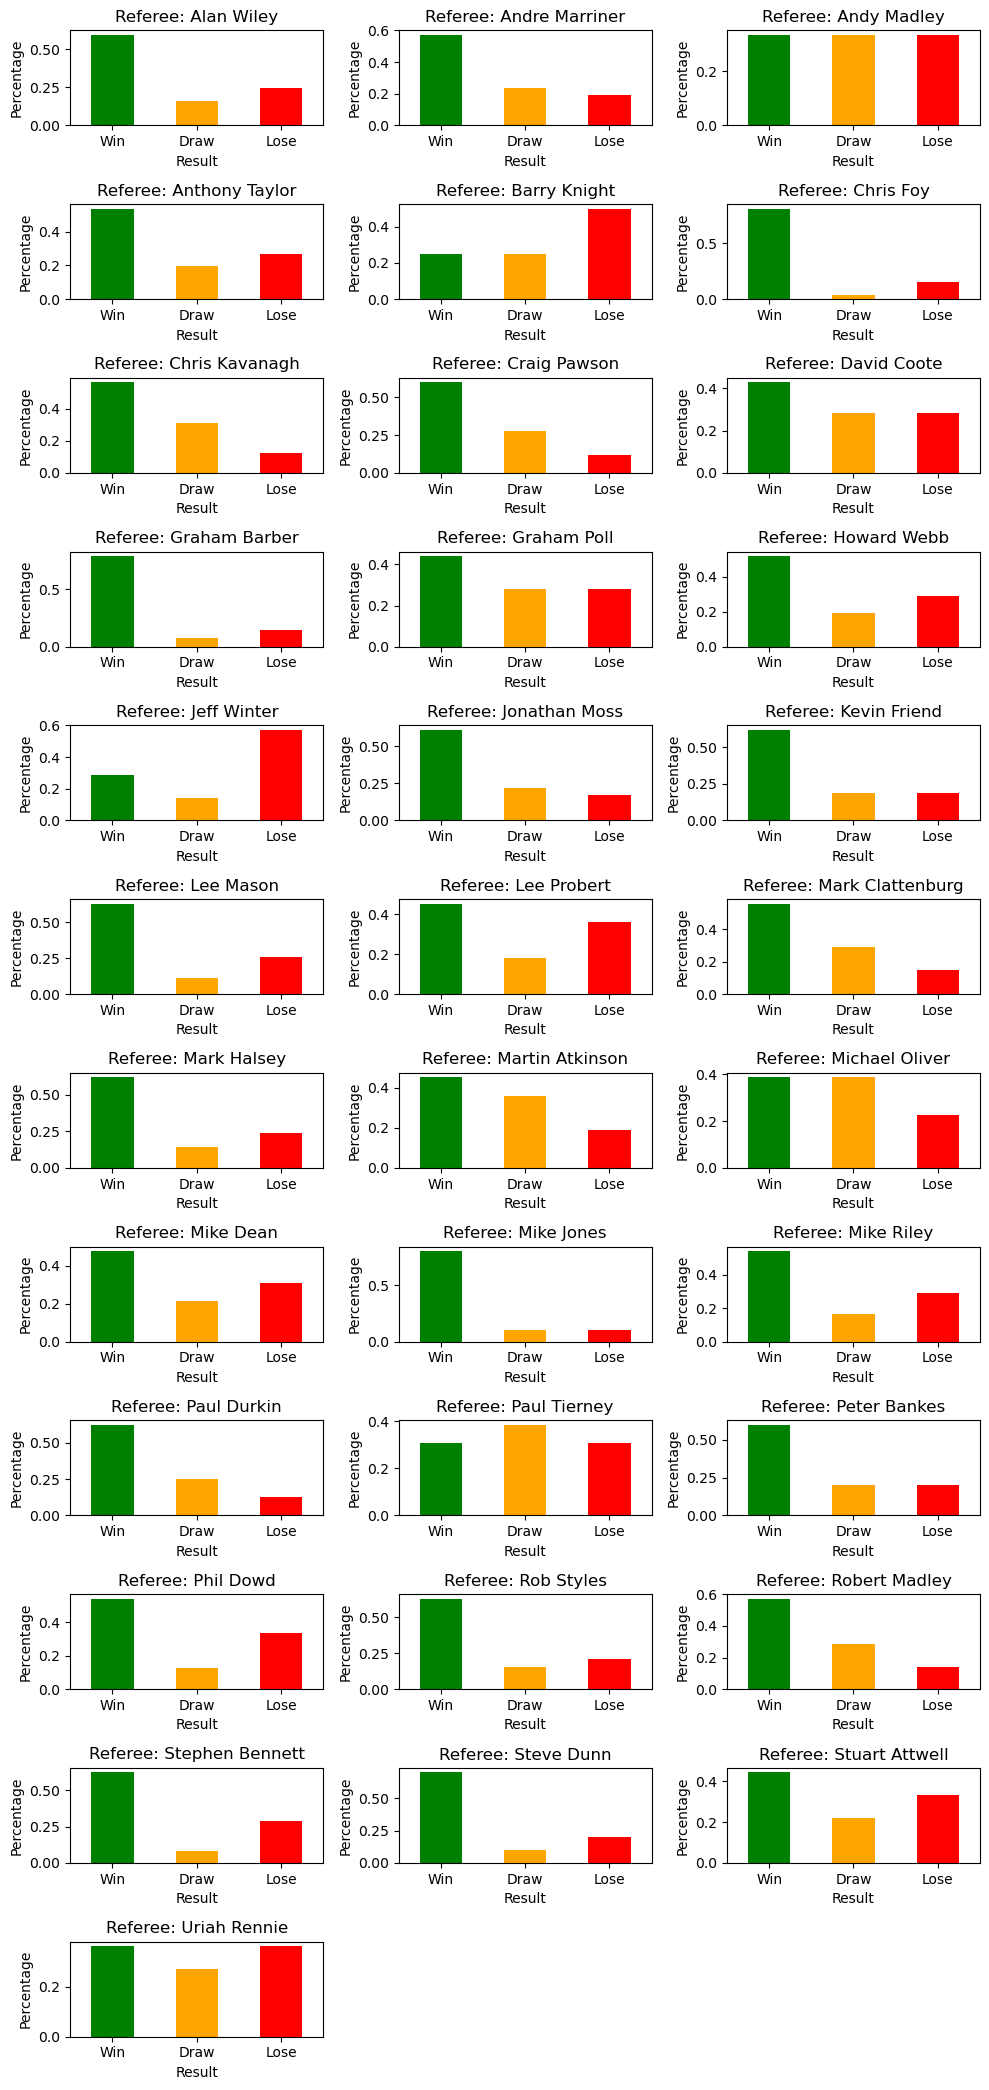

In [13]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Tạo GridSpec với số hàng và số cột tùy chọn
num_referees = len(result_by_referee_percentage.index)
num_cols = 3  # Số cột trong mỗi hàng
num_rows = -(-num_referees // num_cols)  # Số hàng được làm tròn lên

# Tạo GridSpec
gs = GridSpec(num_rows, num_cols)

# Vẽ nhiều đồ thị con trong một đồ thị lớn
fig = plt.figure(figsize=(10, 1.75* num_rows))  # Kích thước của đồ thị lớn
for i, referee in enumerate(result_by_referee_percentage.index):
    row = i // num_cols
    col = i % num_cols
    ax = fig.add_subplot(gs[row, col])
    
    # Vẽ biểu đồ cột cho từng trọng tài
    result_by_referee_percentage.loc[referee].plot(kind='bar', ax=ax, color=['green', 'orange', 'red'])
    
    ax.set_title(f"Referee: {referee}")
    ax.set_xlabel("Result")
    ax.set_ylabel("Percentage")
    ax.set_xticklabels(['Win', 'Draw', 'Lose'], rotation=0)
    
plt.tight_layout()
plt.show()

Nhận xét:
- Đại đa số các trận đấu đều có %W, %D cao hơn %L, điều này cho thấy rằng trọng tài không ảnh hưởng <br/>
nhiều đến kết quả trận đấu. Do đó sẽ không sử dụng biến referee trong quá trình training

### 3. Phong độ (win_before_team1, lose_before_team1, draw_before_team1) của đội đến kết quả

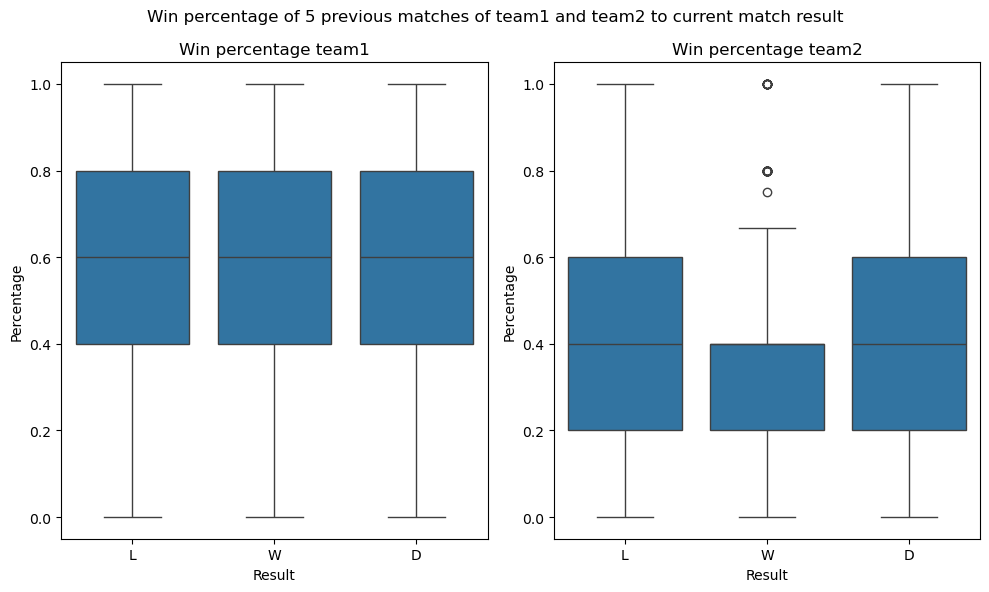

In [14]:
# Vẽ biểu đồ box plot thể hiện ảnh hưởng của tỷ lệ thắng 5 trận trước đó của 2 team đến kết quả trận đấu
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.boxplot(x='result', y='win_before_team1', data=arsenal_df, ax=axes[0])
axes[0].set_title('Win percentage team1')
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.boxplot(x='result', y='win_before_team2', data=arsenal_df, ax=axes[1])
axes[1].set_title('Win percentage team2')
axes[1].set_xlabel('Result')
axes[1].set_ylabel('Percentage')

plt.suptitle("Win percentage of 5 previous matches of team1 and team2 to current match result")
plt.tight_layout()

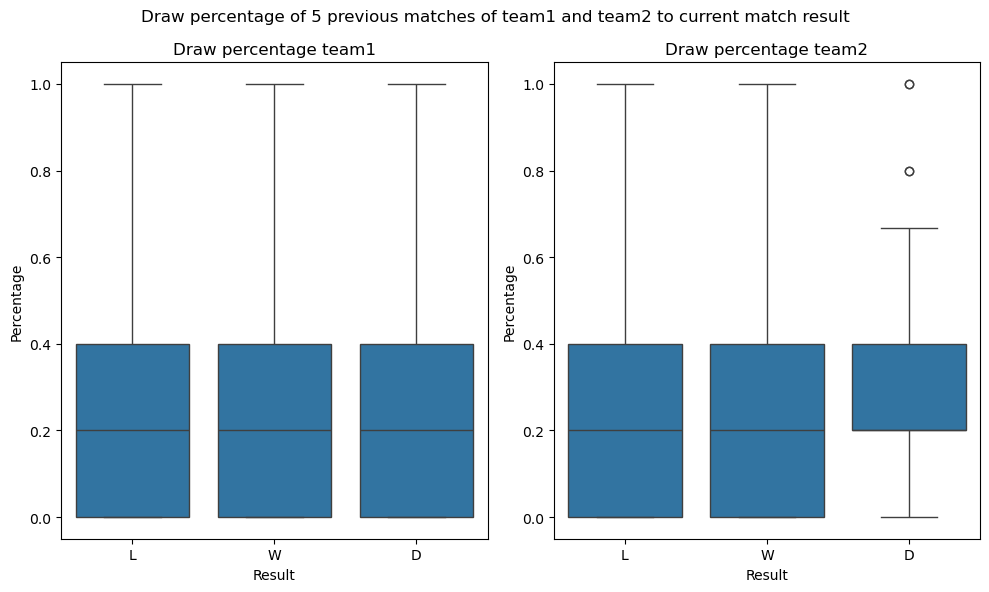

In [15]:
# Vẽ biểu đồ box plot thể hiện ảnh hưởng của tỷ lệ hoà 5 trận trước đó của 2 team đến kết quả trận đấu
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.boxplot(x='result', y='draw_before_team1', data=arsenal_df, ax=axes[0])
axes[0].set_title('Draw percentage team1')
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.boxplot(x='result', y='draw_before_team2', data=arsenal_df, ax=axes[1])
axes[1].set_title('Draw percentage team2')
axes[1].set_xlabel('Result')
axes[1].set_ylabel('Percentage')

plt.suptitle("Draw percentage of 5 previous matches of team1 and team2 to current match result")
plt.tight_layout()

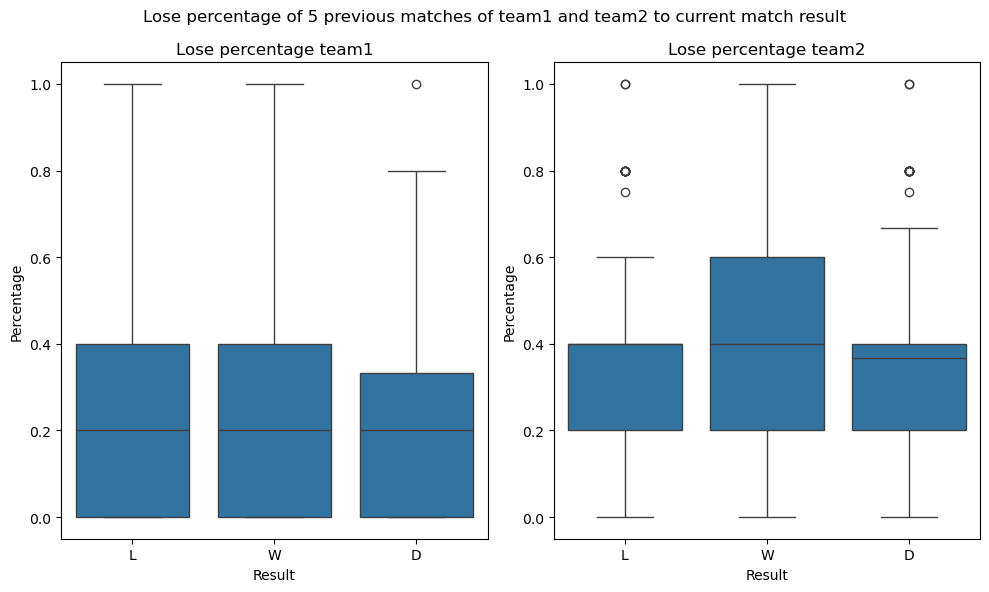

In [16]:
# # Vẽ biểu đồ box plot thể hiện ảnh hưởng của tỷ lệ thua 5 trận trước đó của 2 team đến kết quả trận đấu
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.boxplot(x='result', y='lose_before_team1', data=arsenal_df, ax=axes[0])
axes[0].set_title('Lose percentage team1')
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.boxplot(x='result', y='lose_before_team2', data=arsenal_df, ax=axes[1])
axes[1].set_title('Lose percentage team2')
axes[1].set_xlabel('Result')
axes[1].set_ylabel('Percentage')

plt.suptitle("Lose percentage of 5 previous matches of team1 and team2 to current match result")
plt.tight_layout()

Nhận xét: team1 (đội đi dự đoán), team2 (đội đối thủ)
- Với đồ thị `phần trăm thắng` của 2 đội 5 trận gần đây, ta thấy rằng:
    + Đồ thị biểu diễn cho team1 không có sự thay đổi   
    => `Không chọn win_before_team1`
    + Nếu team2 có % thắng cao thì tỉ lệ thua, hoà của team1 khi đấu với team2 sẽ cao và tỉ lệ thắng thấp
- Với đồ thị `phần trăm hoà` của 2 đội 5 trận gần đây, ta thấy rằng:
    + Đồ thị biểu diễn cho team1 không có sự thay đổi
    => `Không chọn draw_before_team1`
    + Nếu team2 có % hoà cao thì tỉ lệ thắng, hoà của team1 khi đấu với team2 sẽ cao và tỉ lệ thua thấp
- Với đồ thị `phần trăm thua` của 2 đội 5 trận gần đây, ta thấy rằng:
    + Nhìn vào đồ thị có thể thấy rằng % thua của team1 và team2 không ảnh hưởng nhiều đến kết quả trận đấu, vì tất cả boxplot đều có giá trị gần như nhau

Vậy sẽ đưa các biến: `win_before_team2`,`draw_before_team2`, `lose_before_team1`, `lose_before_team2` vào quá trình training

### 4. Xem sét sự ảnh hưởng của opponent đến kết quả

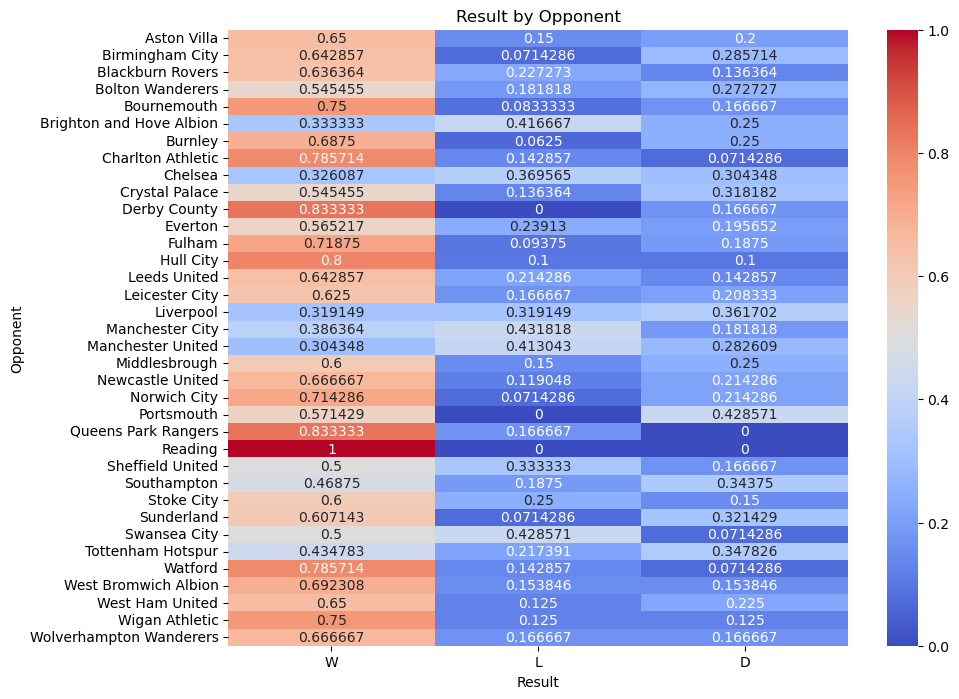

In [17]:
# Tạo bảng dữ liệu cho heatmap
min_usage = 5 
popular_formations = arsenal_df['opponent'].value_counts()[arsenal_df['opponent'].value_counts() > min_usage].index
filtered_df = arsenal_df[arsenal_df['opponent'].isin(popular_formations)]

# Tính toán tỷ lệ phần trăm thay vì số trận
formation_result = filtered_df.groupby(['opponent', 'result']).size().unstack().fillna(0).reindex(columns=["W", "L", "D"])
formation_result = formation_result.div(filtered_df.groupby(['opponent']).size(), axis=0)

# Vẽ biểu đồ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(formation_result, annot=True, cmap='coolwarm', fmt='g')
plt.title('Result by Opponent')
plt.xlabel('Result')
plt.ylabel('Opponent');

Nhận xét: 
- Tỉ lệ thắng, thua, hoà có một sự khác biệt khi đấu với các đội khác nhau
    + Lúc thì %W thắng cao nhất, lúc thì %L cao nhất
    + Do đó sẽ đưa biến opponent vào quá trình training

### 5. Xem xét sự ảnh hưởng của Formation đến kết quả thi đấu

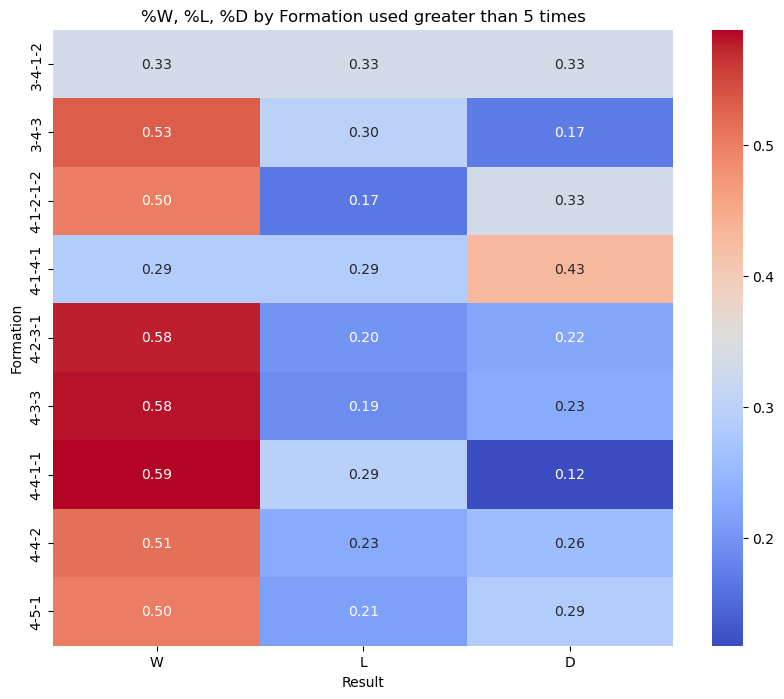

In [18]:
# Lọc dữ liệu để chỉ chọn các đội hình được sử dụng hơn 5 lần
min_usage = 5 
popular_formations = arsenal_df['formation_team1'].value_counts()[arsenal_df['formation_team1'].value_counts() > min_usage].index
filtered_df = arsenal_df[arsenal_df['formation_team1'].isin(popular_formations)]

# Tính toán tỷ lệ phần trăm thay vì số trận
formation_result = filtered_df.groupby(['formation_team1', 'result']).size().unstack().fillna(0).reindex(columns=["W", "L", "D"])
formation_result = formation_result.div(filtered_df.groupby(['formation_team1']).size(), axis=0)

# Vẽ biểu đồ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(formation_result, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('%W, %L, %D by Formation used greater than 5 times')
plt.xlabel('Result')
plt.ylabel('Formation')
plt.show()

Nhận xét: 
- Đại đa số đội hình khi dùng thì %W luôn là cao nhất, %L thì đại đa số cao hơn %D, do đó có thể thấy biến formation không ảnh hưởng nhiều đến kết quả trận đấu
- Sẽ loại bỏ biến formation_team1, formation_team2 ra khỏi quá trình training

### 6. Xem xét sự ảnh hưởng của round đến kết quả

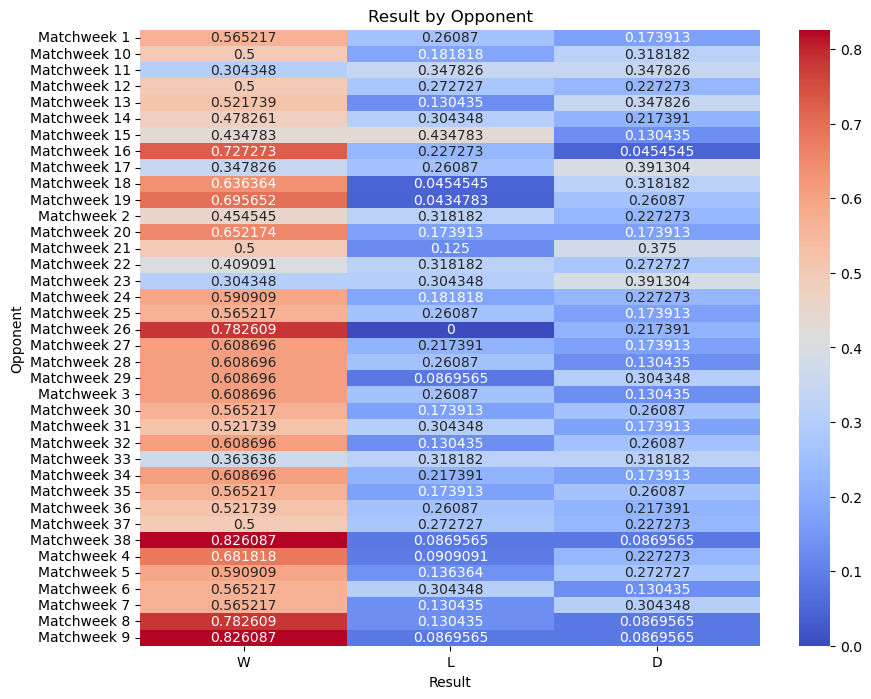

In [19]:
# Tính toán tỷ lệ phần trăm thay vì số trận
formation_result = filtered_df.groupby(['round', 'result']).size().unstack().fillna(0).reindex(columns=["W", "L", "D"])
formation_result = formation_result.div(filtered_df.groupby(['round']).size(), axis=0)

# Vẽ biểu đồ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(formation_result, annot=True, cmap='coolwarm', fmt='g')
plt.title('Result by Opponent')
plt.xlabel('Result')
plt.ylabel('Opponent');

C:\Users\Think Pad\AppData\Local\Temp\ipykernel_21936\1372612183.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  round_group_result_percentage = arsenal_df.groupby('round_group')['result'].value_counts(normalize=True).unstack().fillna(0)


<Figure size 1200x600 with 0 Axes>

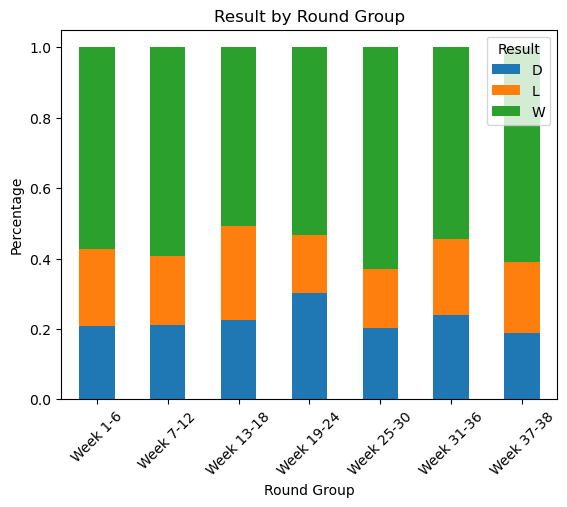

In [20]:
# Trích xuất số từ giá trị chuỗi của cột "round"
arsenal_df['week'] = arsenal_df['round'].str.extract(r'(\d+)').astype(int)

# Tạo các nhóm lớn hơn cho các vòng đấu
bins = [1, 6, 12, 18, 24, 30, 36, 39]  # Gom mỗi 6 vòng đấu thành một nhóm
labels = ['Week 1-6', 'Week 7-12', 'Week 13-18', 'Week 19-24', 'Week 25-30', 'Week 31-36', 'Week 37-38']
arsenal_df['round_group'] = pd.cut(arsenal_df['week'], bins=bins, labels=labels, right=False)

# Tính toán tỷ lệ phần trăm thắng, hòa, thua theo nhóm vòng đấu
round_group_result_percentage = arsenal_df.groupby('round_group')['result'].value_counts(normalize=True).unstack().fillna(0)

# Vẽ biểu đồ bar chart
plt.figure(figsize=(12, 6))
round_group_result_percentage.plot(kind='bar', stacked=True)
plt.title('Result by Round Group')
plt.xlabel('Round Group')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Result');

Nhận xét:
- Tỉ lệ thắng luôn cao hơn tỉ lệ thua, hoà và tỉ lệ thua đại đa số cao hơn tỉ lệ hoà<br/>
Do đó có thể thấy tỉ lệ thắng, thua, hoà không có sự thay đổi theo vòng đấu, do đó sẽ loại bỏ biến round ra khỏi quá trình training

### 7. Ảnh hưởng của lịch sử đối đầu đến biến result

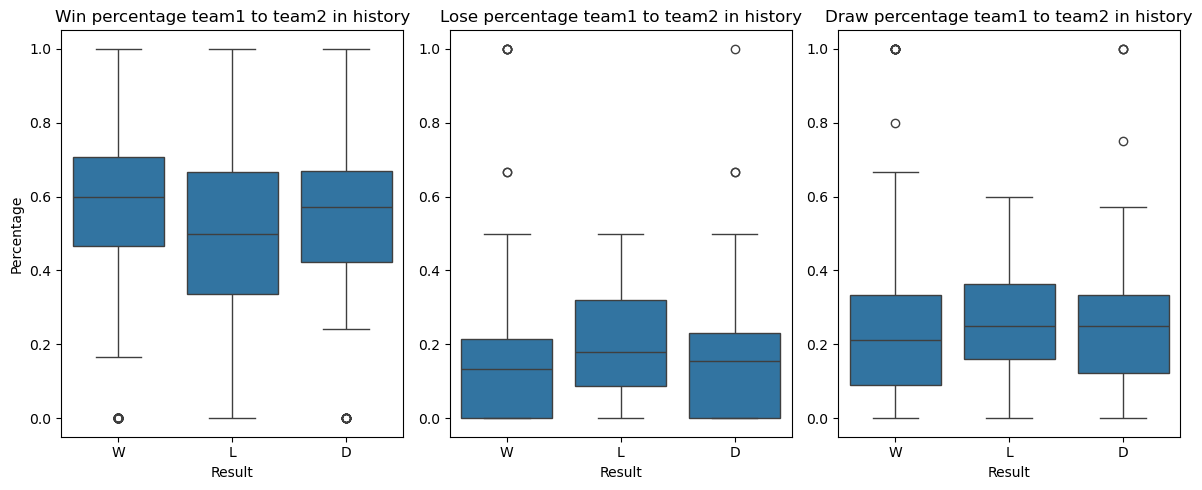

In [21]:
# Vẽ biểu đồ box plot thể hiện ảnh hưởng của tỷ lệ thắng 5 trận trước đó của 2 team đến kết quả trận đấu
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
order = ['W', 'L', 'D']

sns.boxplot(x='result', y='history_team1_win_team2', data=arsenal_df, ax=axes[0], order=order)
axes[0].set_title('Win percentage team1 to team2 in history')
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Percentage')

sns.boxplot(x='result', y='history_team1_lose_team2', data=arsenal_df, ax=axes[1], order=order)
axes[1].set_title('Lose percentage team1 to team2 in history')
axes[1].set_xlabel('Result')
axes[1].set_ylabel(None)

sns.boxplot(x='result', y='history_team1_draw_team2', data=arsenal_df, ax=axes[2], order=order)
axes[2].set_title('Draw percentage team1 to team2 in history')
axes[2].set_xlabel('Result')
axes[2].set_ylabel(None)

plt.tight_layout()

Nhận xét:
- Khi team1 có %W gặp team2 trước đây cao thì tỉ lệ thắng, hoà của team1 khi đấu với team2 trong trận tiếp theo sẽ cao và tỉ lệ thua thấp
- Khi team1 có %W gặp team2 trước đât cao thì tỉ lệ thua, hoà của team1 khi đấu với team2 trong trận tiếp theo sẽ cao và tỉ lệ thắng thấp
- Còn khi %D cao thì tỉ lệ thua của team1 lại cao, tỉ lệ thắng, hoà xấp xỉ nhau
Vậy lịch sử gặp nhau thông qua 3 đặc trưng (history_team1_win_team2, history_team1_draw_team2, history_team1_lose_team2) sẽ được đưa vào quá trình training vì nó có ảnh hưởng đến kết quả trận đấu

### 8. Xem xét sự ảnh hưởng của biến is_opponent_big6 đến kết quả

In [22]:
result_count = arsenal_df.groupby(['is_opponent_big6', 'result']).size().unstack().reindex(["W", "L", "D"], axis=1)
is_big6_count = arsenal_df.groupby(['is_opponent_big6']).size()

result_count, is_big6_count

(result              W   L    D
 is_opponent_big6              
 0                 415  99  132
 1                  81  80   68,
 is_opponent_big6
 0    646
 1    229
 dtype: int64)

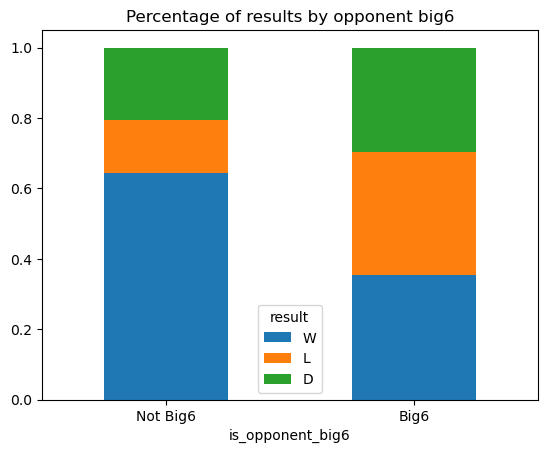

In [23]:
result_percentage = result_count.div(is_big6_count, axis=0)
result_percentage.plot(kind='bar', stacked=True)
plt.title("Percentage of results by opponent big6")
plt.xticks(ticks=[0, 1], labels=['Not Big6', 'Big6'], rotation=0);

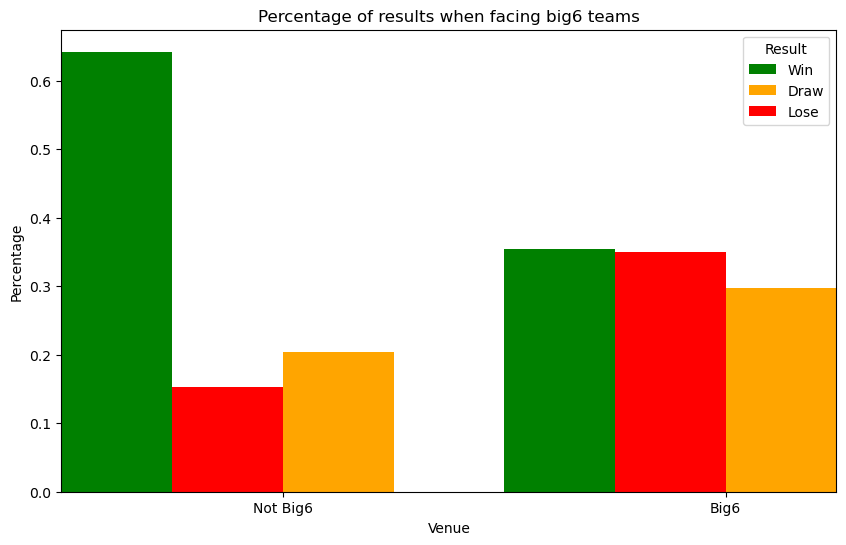

In [24]:
# Thay vì gôm W, L, D vào 1 cột thì ta sẽ tách ra:
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ biểu đồ cho kết quả Win
result_percentage['W'].plot(kind='bar', ax=ax, color='green', position=2, width=0.25, label='Win')

# Vẽ biểu đồ cho kết quả Draw
result_percentage['D'].plot(kind='bar', ax=ax, color='orange', position=0, width=0.25, label='Draw')

# Vẽ biểu đồ cho kết quả Lose
result_percentage['L'].plot(kind='bar', ax=ax, color='red', position=1, width=0.25, label='Lose')

plt.title("Percentage of results when facing big6 teams")
plt.xlabel("Venue")
plt.ylabel("Percentage")
plt.xticks(ticks=[0, 1], labels=['Not Big6', 'Big6'], rotation=0);
plt.legend(title='Result')

plt.show()

Nhận xét:
- Khi gặp Big6 thì tỉ lệ thua cao hơn rõ rệt, tỉ lệ thắng và hoà thì xấp xỉ nhau
- Khi không gặp Big6 thì tỉ lệ thắng lại cao, và tỉ lệ thua, hoà xấp xỉ nhau
Vậy is_opponent_big6 ảnh hưởng rõ rệt đến kết quả thi đấu của trận hiện tại, do đó sẽ đưa đặc trưng này vào việc dự đoán.

### 9. Xem xét sự ảnh hưởng của season đến kết quả

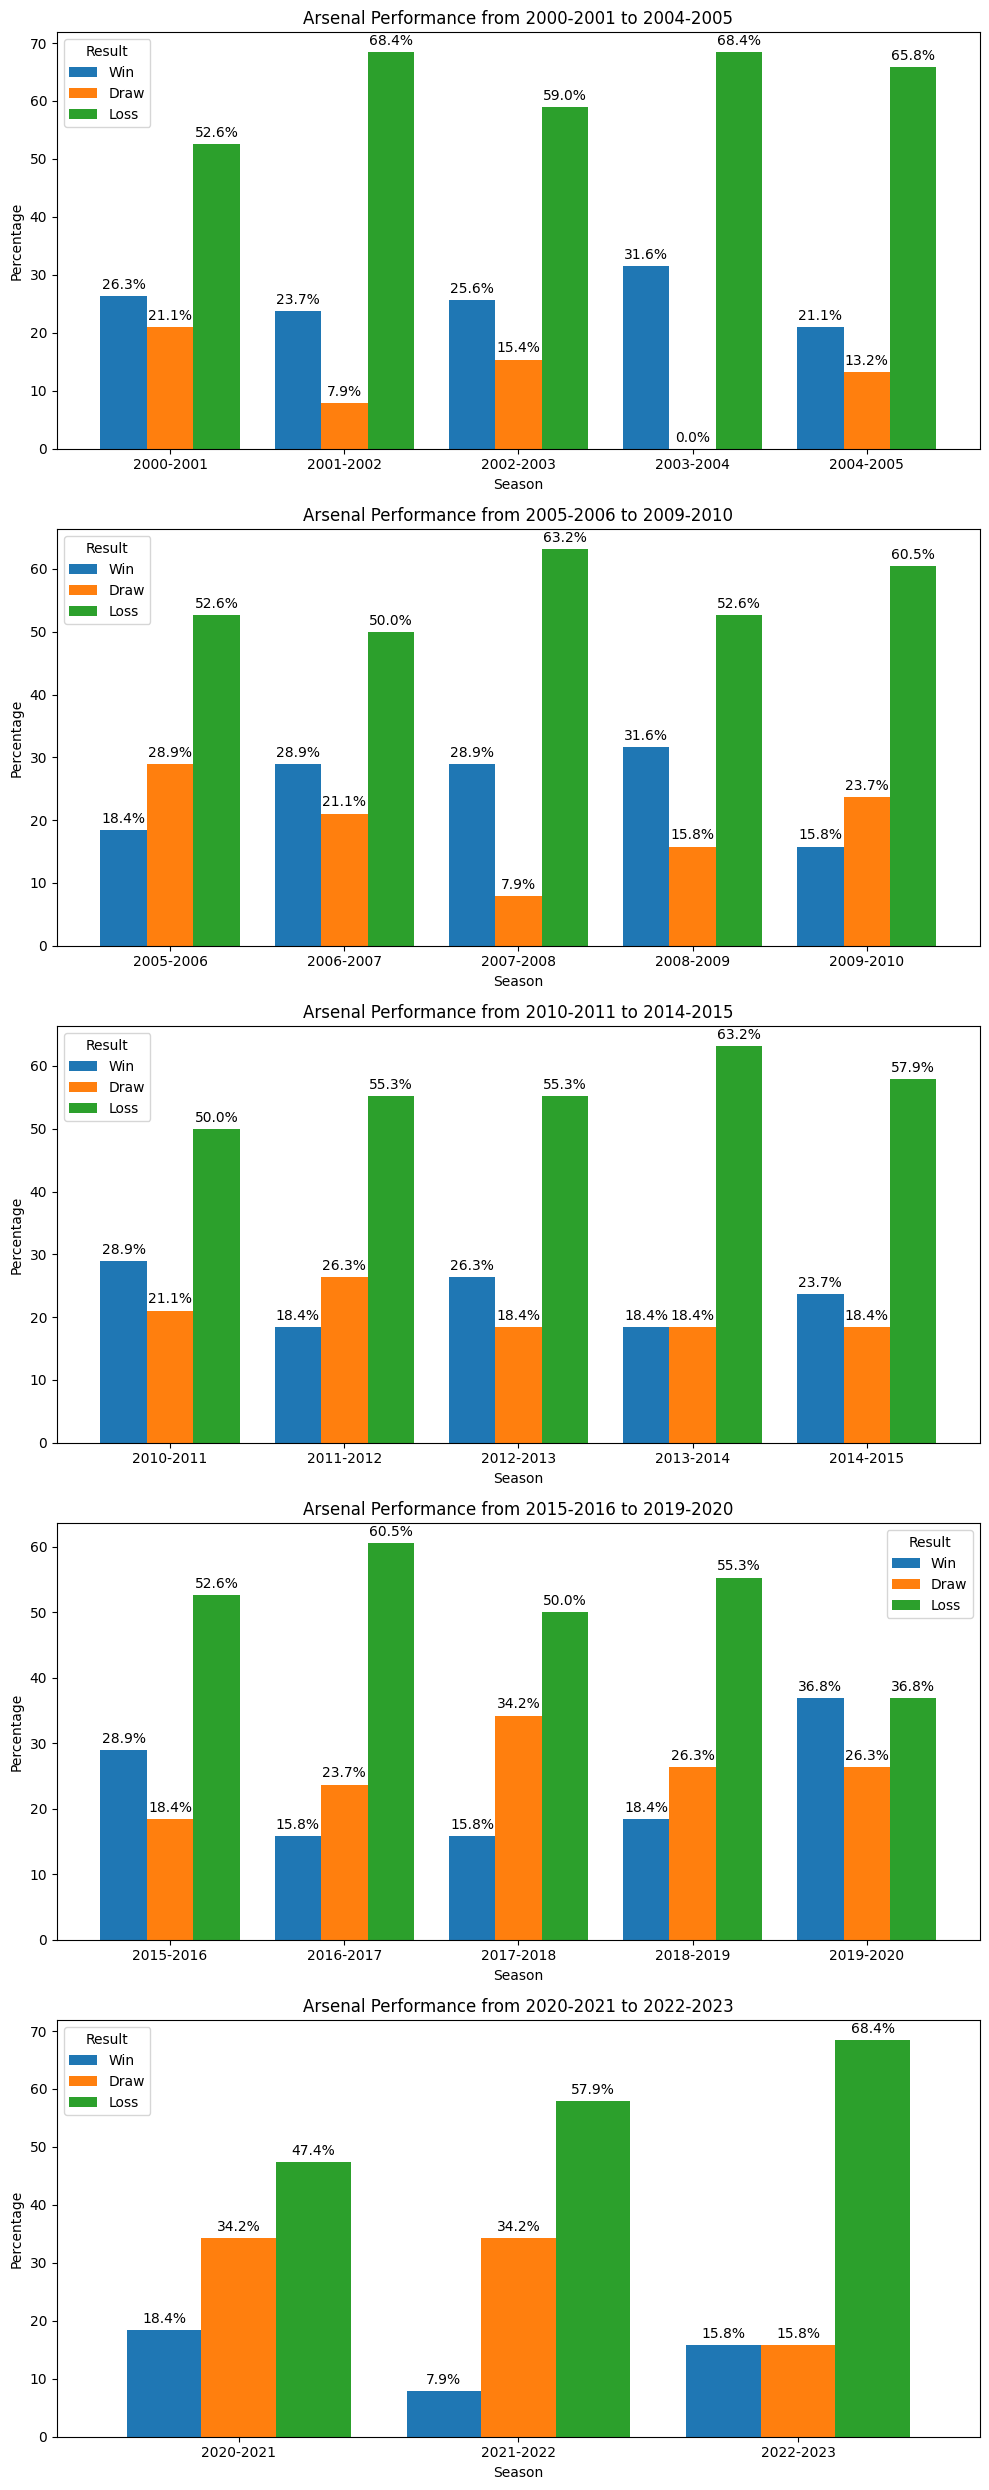

In [8]:
season_values = arsenal_df["season"].unique()
season_groups = [season_values[i:i + 5] for i in range(0, len(season_values), 5)]

# Tạo figure với số lượng subplots phù hợp với số nhóm
num_groups = len(season_groups)
fig, axs = plt.subplots(num_groups, 1, figsize=(10, 5 * num_groups))  # Adjust the size as needed

# Lặp qua mỗi nhóm và vẽ đồ thị
for idx, seasons in enumerate(season_groups):
    # Lọc dữ liệu cho các mùa giải đã chỉ định
    filtered_df = arsenal_df[arsenal_df['season'].isin(seasons)]

    # Tính phần trăm chiến thắng, hòa, thua cho mỗi mùa giải
    result_counts = filtered_df.groupby(['season', 'result']).size().unstack(fill_value=0)
    result_percentages = result_counts.div(result_counts.sum(axis=1), axis=0) * 100

    # Vẽ dữ liệu trong subplot tương ứng
    ax = axs[idx] if num_groups > 1 else axs  # Handle the case of a single subplot
    bars = result_percentages.plot(kind='bar', width=0.8, ax=ax)
    ax.set_title(f'Arsenal Performance from {seasons[0]} to {seasons[-1]}')
    ax.set_xlabel('Season')
    ax.set_ylabel('Percentage')
    ax.legend(title='Result', labels=['Win', 'Draw', 'Loss'])

    # Chỉnh trục x-axis labels nằm ngang
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # Thêm % vào mỗi cột
    for bar_container in bars.containers:
        ax.bar_label(bar_container, fmt='%.1f%%', label_type='edge', padding=3)

# Chỉnh sửa bố cục
plt.tight_layout()
plt.show()

### 10. Xét biến điểm trung bình 5 trận gần nhất last_5_points_team1 và last_5_points_team2

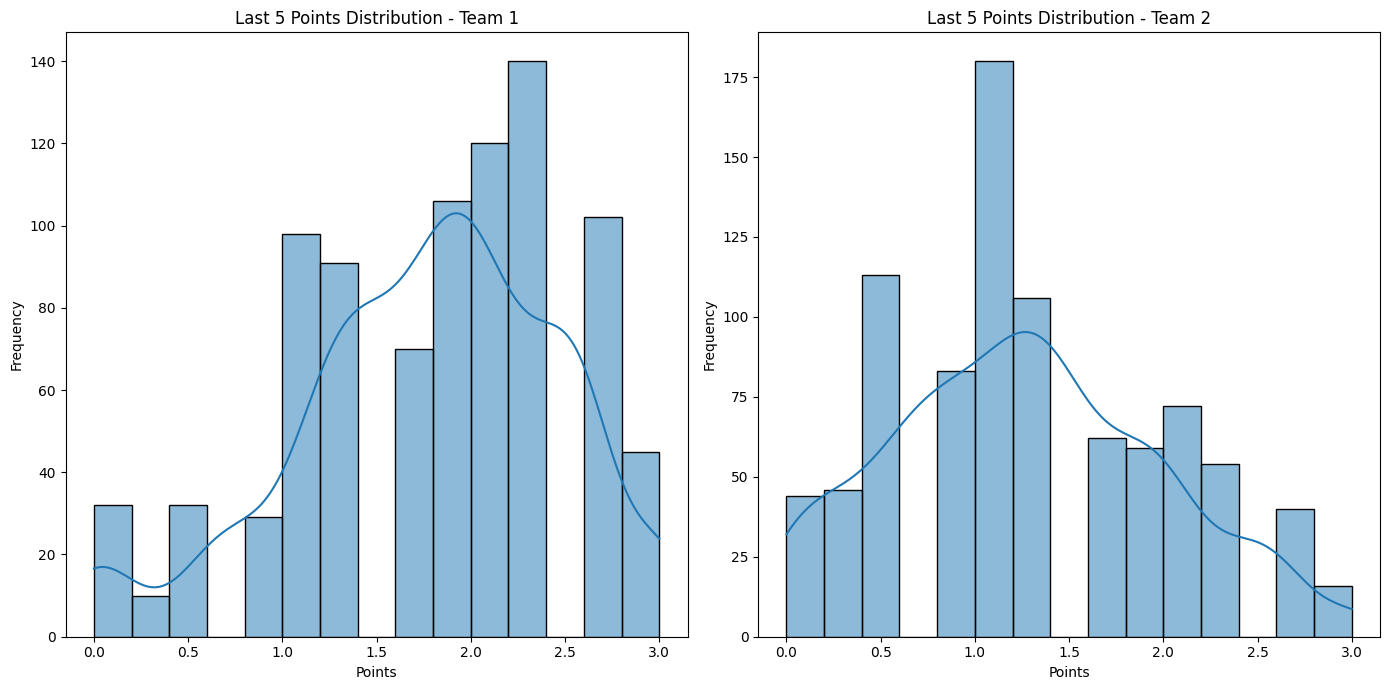

In [7]:
# Trực quan hóa số điểm trong 5 trận gần nhất của cả team1 và team2
plt.figure(figsize=(14, 7))

# Subplot cho team1
plt.subplot(1, 2, 1)
sns.histplot(arsenal_df['last_5_points_team1'], bins=15, kde=True)
plt.title('Last 5 Points Distribution - Team 1')
plt.xlabel('Points')
plt.ylabel('Frequency')

# Subplot cho team2
plt.subplot(1, 2, 2)
sns.histplot(arsenal_df['last_5_points_team2'], bins=15, kde=True)
plt.title('Last 5 Points Distribution - Team 2')
plt.xlabel('Points')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Kết luận
Các đặc trưng sẽ dùng cho việc dự đoán:
- venue
- Các đặc trưng về phong độ 2 đội: `win_before_team2`,`draw_before_team2`, `lose_before_team1`, `lose_before_team2`
- opponent
- Các đặc trưng về lịch sử đối đầu: history_team1_win_team2, history_team1_draw_team2, history_team1_lose_team2
- is_opponent_big6
- Cột date_time vẫn sẽ giữ lại nhưng không đưa vào dự đoán vì mục đích là dùng để tính toán phong độ, <br/>
lịch sử đối đầu tại giai đoạn test